In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import pickle
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

train, test = load_traffic_sign_data(training_file, testing_file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']




In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (34799, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


In [5]:
# preprocessing features
def preprocess_features(X):
  X_yuv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0] for img in X])
  X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])
  X_yuv = np.expand_dims(X_yuv, axis=-1)  # Keep single-channel shape
  X_yuv = X_yuv.astype(np.float32)
  X_yuv -= np.mean(X_yuv, axis=0)
  X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)
  return X_yuv

X_train_norm=preprocess_features(X_train)
X_test_norm=preprocess_features(X_test)



In [6]:
#train-test validation
test_size=0.2
X_train_norm,X_val_norm,y_train,y_val=train_test_split(X_train_norm,y_train,test_size=test_size,random_state=42)

In [7]:
#converting grayscale images to 3 channel format for efficienetb7
X_train_norm = np.repeat(X_train_norm, 3, axis=-1)
X_val_norm = np.repeat(X_val_norm, 3, axis=-1)
X_test_norm = np.repeat(X_test_norm, 3, axis=-1)

In [8]:
# def resize_images(images, target_size=(224, 224)):
#     resized_images = [tf.image.resize(img, target_size).numpy() for img in images]
#     return np.array(resized_images, dtype=np.float32)

# X_train_resized = resize_images(X_train_norm)
# X_val_resized = resize_images(X_val_norm)
# X_test_resized = resize_images(X_test_norm)

In [9]:
# Optimized Data Augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1
)

# EfficientNetB7 Model (Fine-Tuning Enabled)
def create_efficientnet_model(input_shape, n_classes):
    base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze EfficientNet layers for fine-tuning

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (32, 32, 3)
n_classes = 43
model = create_efficientnet_model(input_shape, n_classes)

# Compile Model with Lower Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 32, 32, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 65,551,298 (250.06 MB)

 Trainable params: 65,240,571 (248.87 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [12]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training Parameters
BATCHSIZE = 64  # Reduced batch size due to larger model
EPOCHS = 70  # Increased epochs

# Train Model
history = model.fit(
    image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_norm, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Save Model Weights
model.save_weights('efficientnetb7_traffic_sign.weights.h5')
print("Model training complete. Weights saved successfully.")


Epoch 1/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 369s 456ms/step - accuracy: 0.0275 - loss: 4.0552 - val_accuracy: 0.0461 - val_loss: 3.7142
Epoch 2/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - accuracy: 0.0474 - loss: 3.7002 - val_accuracy: 0.1108 - val_loss: 3.4806
Epoch 3/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.0733 - loss: 3.5483 - val_accuracy: 0.1343 - val_loss: 3.2680
Epoch 4/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 61s 139ms/step - accuracy: 0.1003 - loss: 3.3722 - val_accuracy: 0.1795 - val_loss: 3.0240
Epoch 5/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.1383 - loss: 3.1956 - val_accuracy: 0.2293 - val_loss: 2.7619
Epoch 6/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 60s 138ms/step - accuracy: 0.1799 - loss: 3.0106 - val_accuracy: 0.2728 - val_loss: 2.5339
Epoch 7/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 61s 139ms/step - accuracy: 0.2149 - loss: 2.8467 - val_accuracy: 0.3023 - val_loss: 2.3706
Epoch 8/70
435/435 ━━━━━━━━━━━━━━━━━━━━ 88s 154ms/step - accuracy: 0.2430 - loss: 

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9069 - loss: 0.4197
Test Accuracy: 0.9041, Test Loss: 0.4292


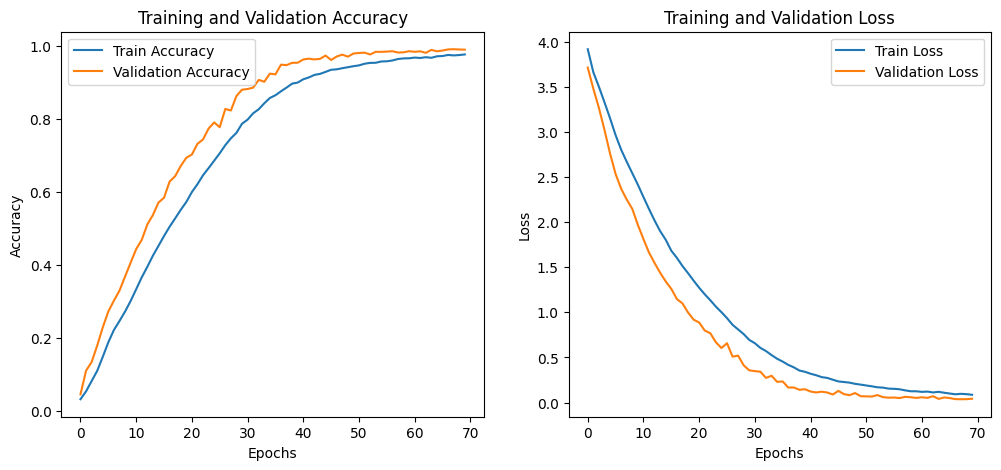

In [14]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

  # Generate accuracy & loss graph
plot_accuracy_loss(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step


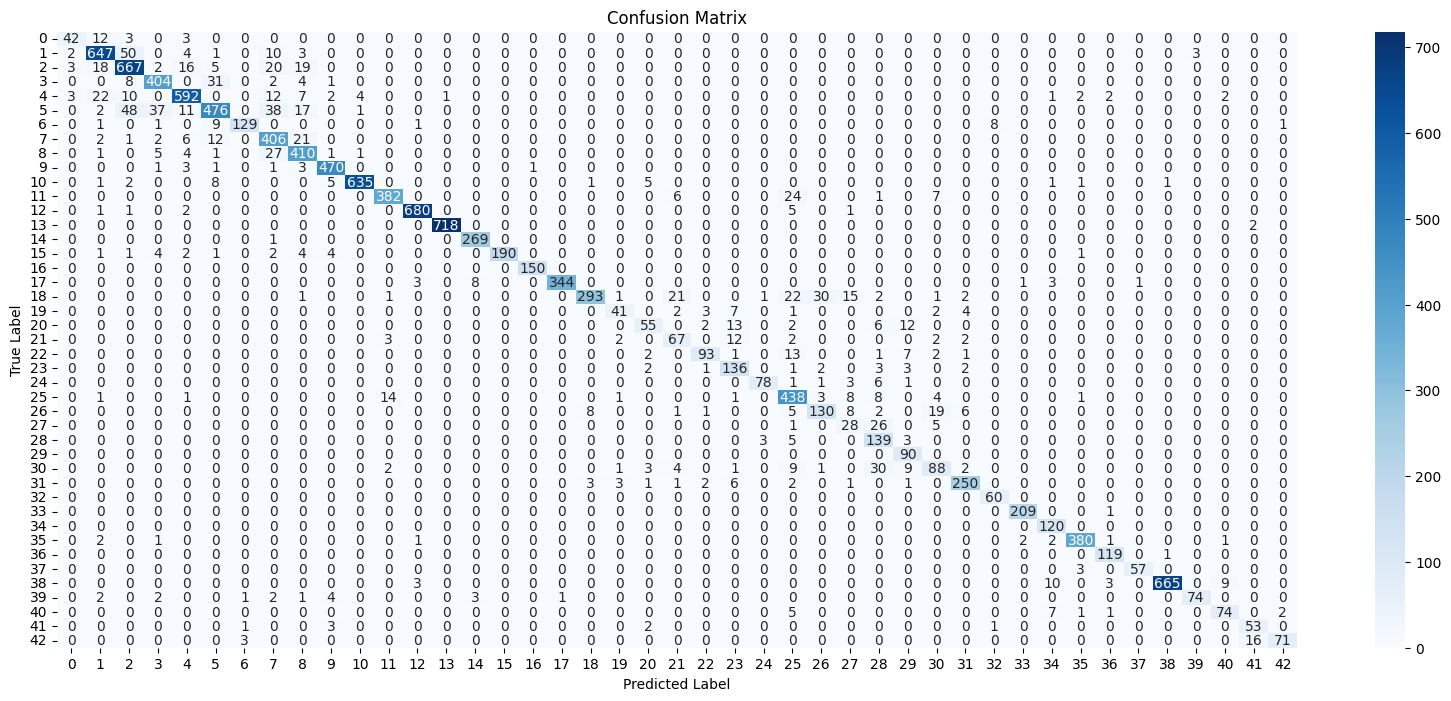

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        60
           1       0.91      0.90      0.90       720
           2       0.84      0.89      0.87       750
           3       0.88      0.90      0.89       450
           4       0.92      0.90      0.91       660
           5       0.87      0.76      0.81       630
           6       0.96      0.86      0.91       150
           7       0.78      0.90      0.84       450
           8       0.84      0.91      0.87       450
           9       0.96      0.98      0.97       480
          10       0.99      0.96      0.98       660
          11       0.95      0.91      0.93       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.96      1.00      0.98       270
          15       1.00      0.90      0.95       210
          16       0.99      1.00      1.00       150
    

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


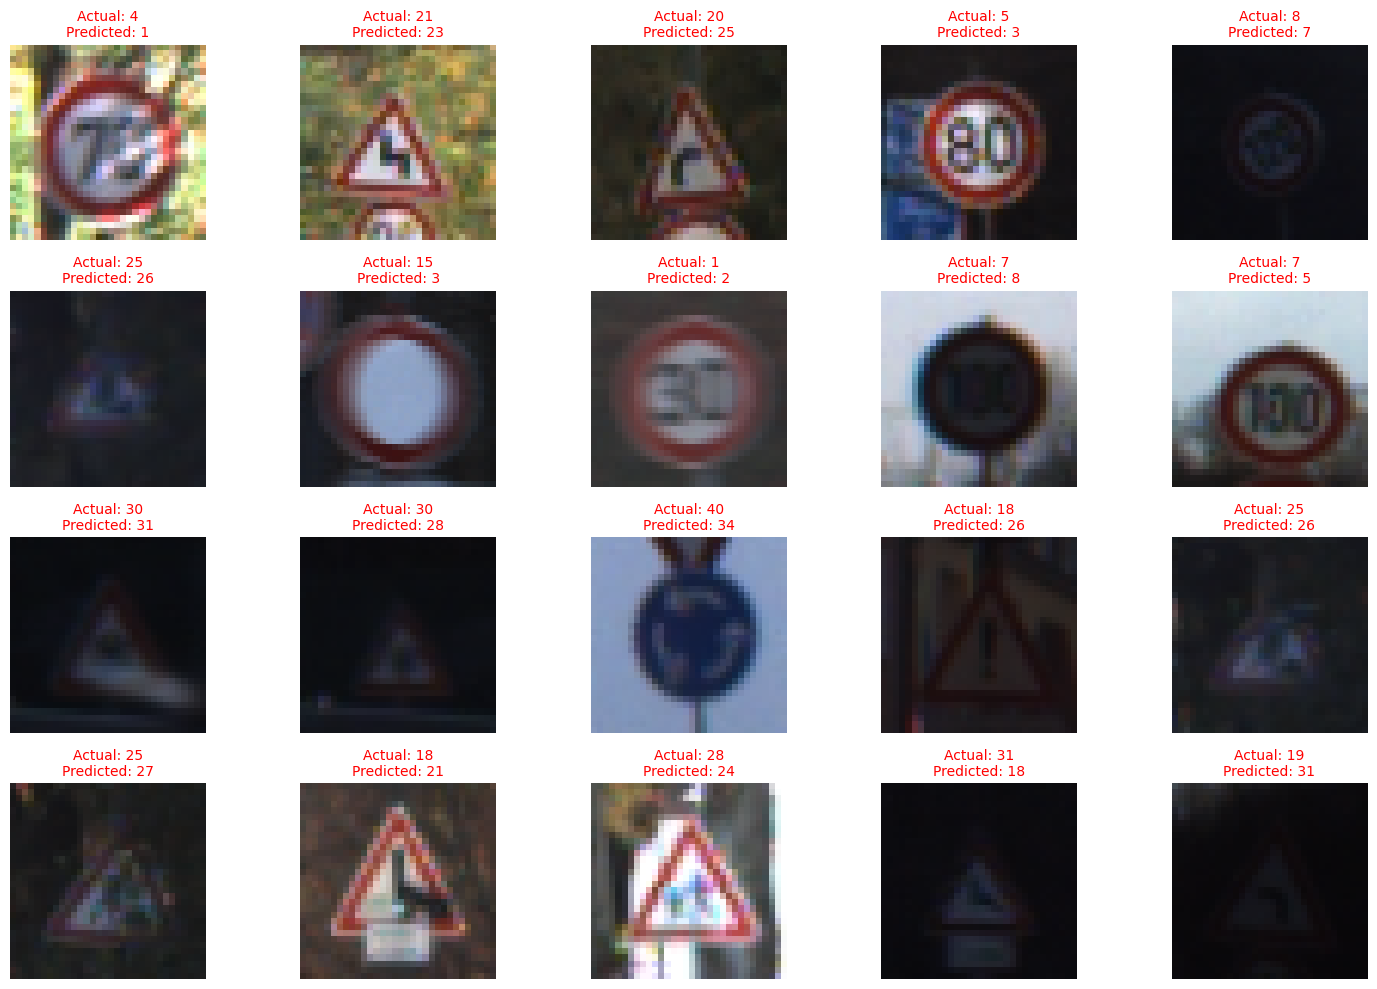

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Find misclassified indices
misclassified_idx = np.where(y_pred != y_test)[0]

# Number of misclassified images to display
num_images = min(20, len(misclassified_idx))  # Show up to 20 misclassified images

# Plot misclassified images with actual & predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:num_images]):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = y_test[idx]
    predicted_label = y_pred[idx]

    # Title showing Actual vs Predicted
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

